MeshNet architecture based on https://arxiv.org/pdf/1612.00940.pdf

"End-to-end learning of brain tissue segmentation
from imperfect labeling"
Jun 2017
Alex Fedorov∗†, Jeremy Johnson‡
, Eswar Damaraju∗†, Alexei Ozerin§
, Vince Calhoun∗†, Sergey Plis∗†

In [1]:
!ls
#!ls ./stage1_train

datalab


In [2]:
# https://stackoverflow.com/questions/48875783/how-to-upload-many-files-to-google-colab

#### FIRST WE SHALL FUSE THE DRIVE
#### CUZ THATS WHAT YOU DO

# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()


# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


# Create a directory and mount Google Drive using that directory.
!mkdir -p Drive
!google-drive-ocamlfuse My Drive

# Navigate to our project directory
import os
#os.chdir('/content/Drive/Data Science Bowl 2018')

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [3]:
#import os
#os.mknod('/content/Drive/Data Science Bowl 2018/mynewnod.txt') # This works
os.listdir()

['datalab',
 'Drive',
 '.ipython',
 '.config',
 '.forever',
 '.rnd',
 '.gdfuse',
 '.cache',
 '.local']

# Libraries and Global Parameters 

In [0]:
# Remember to turn on GPU!!!

# installing packages
!pip install keras -q
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
!pip install kaggle-cli -q

In [5]:
# Read in kaggle login from text file 
with open('/content/Drive/PWs/kaggle_pw.txt') as f:
    lines = f.readlines()   
f.close()

# remove newline and encapsulate in quotes
user= lines[0].strip('\n').strip(' ')
password= lines[1].strip('\n').strip(' ')


#print('"' + user + '"')
#print(password)
# Download our data straight from Kaggle
!kg download -u "xxx" -p 'xxx' -c data-science-bowl-2018 

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_sample_submission.csv.zip

stage1_sample_submission.csv.zip 100% |#############| Time: 0:00:00  11.9 KiB/s

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_train_labels.csv.zip

stage1_train_labels.csv.zip 100% |##################| Time: 0:00:00   5.2 MiB/s

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_test.zip

stage1_test.zip 100% |##############################| Time: 0:00:00  18.9 MiB/s

downloading https://www.kaggle.com/c/data-science-bowl-2018/download/stage1_train.zip

stage1_train.zip 100% |#############################| Time: 0:00:02  35.0 MiB/s



In [0]:
# Unzip the data
!unzip -q stage1_train.zip -d stage1_train
!unzip -q stage1_test.zip -d stage1_test

In [10]:
# Look at our files
os.chdir('/content/Drive/PWs/')
os.listdir()

['datalab',
 'Drive',
 '.ipython',
 '.config',
 '.kaggle-cli',
 '.forever',
 'stage1_sample_submission.csv.zip',
 'stage1_train.zip',
 '.rnd',
 'stage1_train_labels.csv.zip',
 '.gdfuse',
 'stage1_test.zip',
 'stage1_train',
 '.cache',
 'stage1_test',
 '.local']

In [7]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.util import img_as_bool, img_as_uint, img_as_ubyte, img_as_int
from skimage.transform import resize
from skimage.morphology import label
import random
from random import randint 
from keras import regularizers
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, Dense, \
    UpSampling2D, BatchNormalization, add, Dropout, Flatten
from keras.layers.core import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras import backend as K
from keras.losses import binary_crossentropy, sparse_categorical_crossentropy


####### UPDATE THIS #########
#############################

model_num = 1

#############################
#############################

model_checkpoint_file= 'augmesh_v' + str(model_num) +'.h5'
submission_filename = 'augmesh_v' + str(model_num) +'.csv'

# Change directory
os.chdir('/content/Drive/Data Science Bowl 2018')

# Root folders for test and training data
# Use data in /content since google drive fuse I/O speeds are slow
train_root = "/content/stage1_train"
test_root = "/content/stage1_test"

# Size we resize all images to
#image_size = (128,128)

img_height = 128
img_width = 128
img_channels = 1 # 1 for B&W, 3 for RGB

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#warnings.resetwarnings()

Using TensorFlow backend.


# Preparing the Data

In [8]:
# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
def import_images(root):
    dirs = os.listdir(root)
    filenames=[os.path.join(root,file_id) + "/images/"+file_id+".png" for file_id in dirs]
    images=[imread(imagefile,as_grey=True) for imagefile in filenames]
    resized_images = [ resize(image,(img_width,img_height)) for image in images] 
    Array = np.reshape(np.array(resized_images),
                       (len(resized_images),img_height,img_width,img_channels))
    #Array = np.reshape(np.array(img_as_ubyte(resized_images),dtype=np.uint8).astype(np.uint8),
    #                   (len(resized_images),img_height,img_width,img_channels))
    
    print(Array.mean())
    print(Array.std())

    # Normalize inputs
    Array = ((Array - Array.mean())/Array.std())

    print(Array.mean())
    print(Array.std())
    print(images[0].dtype)
    print(resized_images[0].dtype)
    print(Array[0,0,0,0].dtype)
    return Array, images, filenames, dirs

train_X, train_images, train_filenames, train_dirs = import_images(train_root)

0.16090279665693327
0.24962165076888543
1.4403072432898299e-15
0.9999999999999987
float64
float64
float64


In [0]:
## Import Training Masks
# this takes longer than the training images because we have to
# combine a lot of mask files

# This function creates a single combined mask image 
# when given a list of masks
# Probably a computationally faster way to do this...
def collapse_masks(mask_list):
    for i, mask_file in enumerate(mask_list):        
        if i != 0:
            # combine mask with previous mask in list 
            mask = np.maximum(mask, imread(os.path.join(train_root,mask_file)))
        else:
            # read first mask in
            mask = imread(os.path.join(train_root,mask_file))
    
    return mask

# Import all the masks
train_mask_dirs = [ os.path.join(path, 'masks') for path in os.listdir(train_root) ]
train_mask_files = [ [os.path.join(dir,file) for file in os.listdir(os.path.join(train_root,dir)) ]  for dir in train_mask_dirs]
train_masks = [ collapse_masks(mask_files) for mask_files in train_mask_files ]
resized_train_masks = [ img_as_bool(resize(image,(img_width,img_height))) for image in train_masks] 
train_Y = np.reshape(np.array(resized_train_masks),(len(resized_train_masks),img_height,img_width,img_channels))

In [0]:
# Plot images side by side for a list of datasets
def plot_side_by_side(ds_list,image_num,size=(15,10)):
    print('Image #: ' + str(image_num))
    fig = plt.figure(figsize=size)

    for i in range(len(ds_list)):
        ax1 = fig.add_subplot(1,len(ds_list),i+1)
        ax1.imshow(ds_list[i][image_num])
    plt.show()
    
    
# Plots random corresponding images and masks
def plot_check(ds_list,rand_imgs=None,img_nums=None,size=(15,10)):
    if rand_imgs != None:
        for i in range(rand_imgs):
            plot_side_by_side(ds_list, randint(0,len(ds_list[0])-1),size=size)
    if img_nums != None:
        for i in range(len(img_nums)):
            plot_side_by_side(ds_list,img_nums[i],size=size)

            
# Plot images side by side for a list of datasets
def plot_series(ds_list,img_nums,size=(15,10)):
    num_of_imgs = img_nums[-1] - img_nums[0] + 1
  
    fig = plt.figure(figsize=size)

    for i in range(img_nums[0],img_nums[-1]+1):
     #   print(i)
        ax1 = fig.add_subplot(1,num_of_imgs,i - img_nums[0] + 1)
        ax1.imshow(ds_list[i-1])
    plt.show()
    
    
    
#plot_check([train_images,train_masks],rand_imgs=1,size=(15,7))

In [0]:
# Slice up the images so we don't have to crop them
# we will need to add fill pixels for images that aren't shaped in a multiple 

def create_cropped_image(image, h, w):
    cropped = [image[x:x+h,y:y+w] for x in range(0,image.shape[0],h) for y in range(0,image.shape[1],w)]
    return cropped 
  
# Image size is (HEIGHT, WIDTH)
  
import math

def slice_size(image,divisor):
    h=image.shape[0] # height
    w=image.shape[1] # width
    
    # Number of 'cuts'
    n_v_cuts = math.ceil(image.shape[0] / divisor)
    n_h_cuts = math.ceil(image.shape[1] / divisor)
    
    return (n_v_cuts,n_h_cuts)


def slice_image(image,divisor):
    h=image.shape[0] # height
    w=image.shape[1] # width
    
    # Number of 'cuts'
    n_v_cuts = math.ceil(image.shape[0] / divisor)
    n_h_cuts = math.ceil(image.shape[1] / divisor)
    
    #cropped_images = np.zeros((n_v_cuts,n_h_cuts))
    
   # print('Image shape = ' + str(image.shape))
    #print('Number of vertical cuts: ' + str(n_v_cuts))
    #print('Number of horizontal cuts: ' + str(n_h_cuts)) 

    
    cropped_images = []
    for i in range(n_v_cuts):
      for j in range(n_h_cuts):
        
        a=np.zeros((divisor,divisor),dtype=float) # empty numpy
        b=image[(i*divisor):(i+1)*divisor,(j*divisor):(j+1)*divisor] # data from image
        # combine images
        a[:b.shape[0],:b.shape[1]] += b
     
        
        
        #c=np.pad(b,(divisor-b.shape[0],divisor-b.shape[1])) # resize b to make sure it fits
    #    c=a+b # combine
        
        # append this image to our list of images
        cropped_images.append(a)
        #cropped_images.append(image[(i*divisor):(i+1)*divisor,(j*divisor):(j+1)*divisor])
        
        
    # return cropped images in list and the shape in a tuple
    return cropped_images
    
    #cropped = [image[x:x+h,y:y+w] for x in range(0,image.shape[0],h) for y in range(0,image.shape[1],w)]
  
#sliced_2 = slice_image(train_images[2],128)
#crop_2 = create_cropped_image(train_images[2],128,128)

#print('shape: ' + str(shape_2))

train_sliced = []
masks_sliced = []
slice_sizes = []
for i in range(len(train_images)):
    for image in slice_image(train_images[i],128):
        train_sliced.append(image)
    
    for mask in slice_image(train_masks[i],128):
        masks_sliced.append(mask)
    
    slice_sizes.append(slice_size(train_images[i],128))
        
  #masks_sliced.append()
 # slice_sizes
 # slice_sizes = []
    
#np.reshape(np.array([ resize(image,(img_width,img_height)) for image in images] ),
              #         (len(resized_images),img_height,img_width,img_channels))

In [45]:
print(slice_sizes[0])
print(train_images[0].shape)


(3, 3)
(360, 360)


In [0]:
def assemble_slice(images,shape,divisor):
    a = np.zeros((divisor*shape[0],divisor*shape[1]),dtype=float) # empty numpy
    for i in range(len(images)):
      a[:images[i].shape[0],:images[1].shape[1]] += b
    
    

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


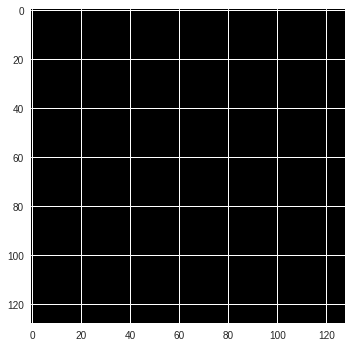

numpy.ndarray

In [69]:

# Display image

#plot_check([train_images],img_nums=[2],size=(10,10))
#a = np.zeros((128,128),dtype=float)
#b = np.ones((64,64),dtype=float)




plt.figure(figsize=(5,5))
imshow(np.zeros((128,128),dtype=float))
plt.show()

type(sliced_2[0][1])

30
Image #: 2


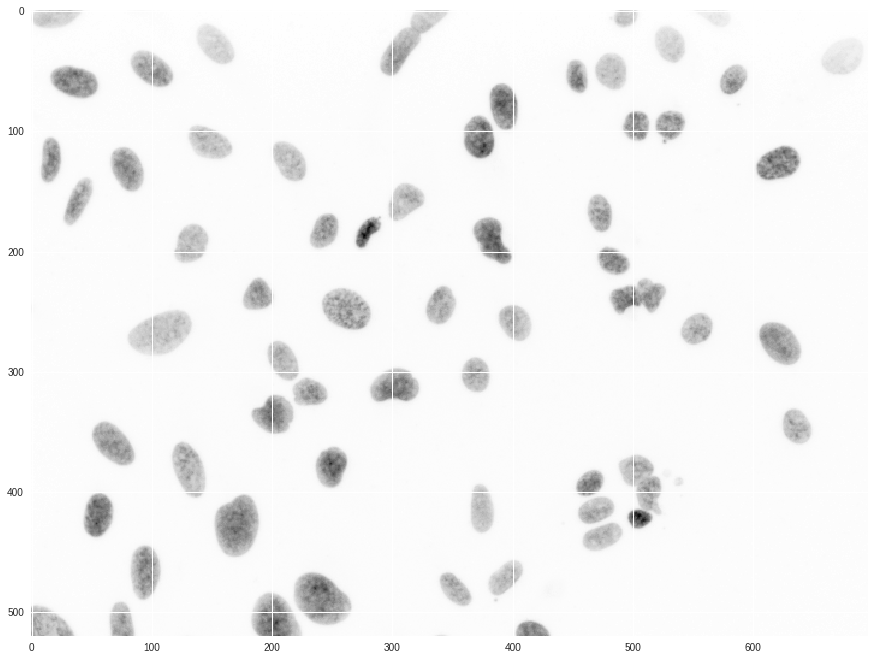

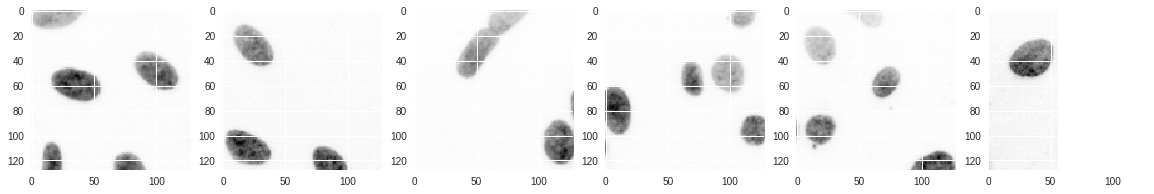

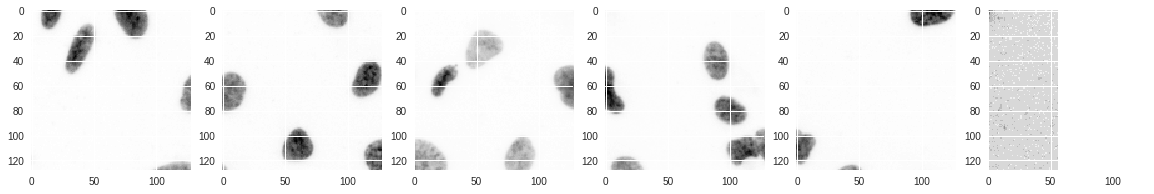

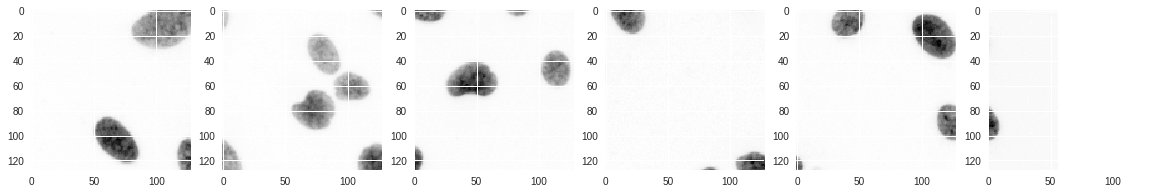

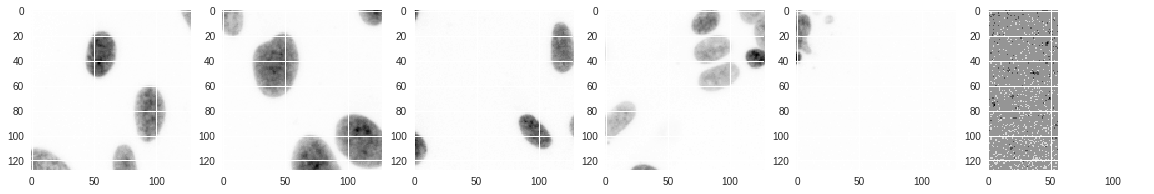

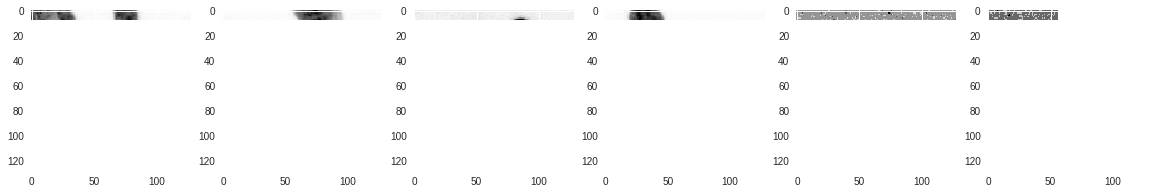

512
640
768


In [87]:
#plot_check([train_images],img_nums=[2],size=(10,10))
print(len(sliced_2))


plot_check([train_images],img_nums=[2],size=(15,15))

plot_series(sliced_2,[1,6], size=(20,10))
plot_series(sliced_2,[7,12], size=(20,10))
plot_series(sliced_2,[13,18], size=(20,10))
plot_series(sliced_2,[19,24], size=(20,10))
plot_series(sliced_2,[25,30], size=(20,10))

### CHeck to make sure I cut the image up correctly


#print(train_images[2][0:128,0:128].shape)
#plot_check([np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3)],img_nums=[0],size=(15,15))

#crop_test = create_cropped_image(train_images[0],train_images[0].shape[0],train_images[0].shape[1])

#plot_check([train_images,train_masks],img_nums=[0],size=(15,15))

print(4*128)
print(5*128)
print(6*128)
#print(train_images[0].shape)
#print(train_masks[0].shape)

In [87]:
6len(sliced_2)
len(crop_2)

30

In [17]:
# Check size of arrays we are inputting to model
# This is important! We need the datasets to be as 
# small as possible to reduce computation time

# Check physical size
print(train_X.shape)
print(train_Y.shape)

# Check memory size
print(train_X.nbytes)
print(train_Y.nbytes)

# Check datatypes
print(train_X.dtype)
print(train_Y.dtype)

(670, 128, 128, 1)
(670, 128, 128, 1)
87818240
10977280
float64
bool


Image #: 507


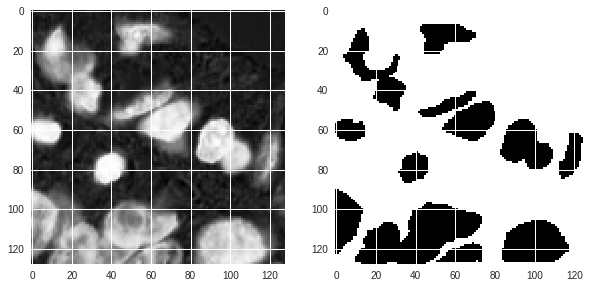

In [30]:
plot_check([np.squeeze(train_X,axis=3),np.squeeze(train_Y,axis=3)],rand_imgs=1,size=(10,7))

# Now Let's Build the Model

In [20]:
# Loss and metric functions for the neural net
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def create_block(x, filters=21, filter_size=(3, 3), activation='relu',dil_rate=1,dropout_rate=0.25):
    x = Conv2D(filters, filter_size, padding='same', activation=activation, dilation_rate = dil_rate) (x)
   # x = BatchNormalization() (x) 
    x = Dropout(dropout_rate) (x)
    return x


## master function for creating a net
def get_net(
        input_shape=(img_height, img_width,img_channels),
        loss=binary_crossentropy,
        lr=0.001,
        n_class=1,
        nb_filters=21,
        dropout_rate=0.2
):
    
    inputs = Input(input_shape)
    
    # Does this help with computation?? 

    # Create layers
    net_body = create_block(inputs,filters=nb_filters,dropout_rate=dropout_rate)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate,dil_rate=2)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate,dil_rate=4)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate,dil_rate=8)
    net_body = create_block(net_body,filters=nb_filters,dropout_rate=dropout_rate)
    classify = Conv2D(n_class,(1,1),activation='sigmoid') (net_body)

    model = Model(inputs=inputs, outputs=classify)
    
    model.compile(optimizer=Adam(lr), loss=loss, metrics=[bce_dice_loss, dice_coef])

    return model

#### CREATE MODEL ##########################################################

my_model = get_net(nb_filters=21,dropout_rate=0.1,loss=binary_crossentropy)

############################################################################

print(my_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 21)      210       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 21)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 21)      3990      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128, 128, 21)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 21)      3990      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 128, 21)      0         
__________

In [0]:
#os.listdir()

In [23]:
# Fit model

earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(model_checkpoint_file, verbose=1, save_best_only=True)
reduce_plateau = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,
                           patience=4,
                           verbose=1,
                        #   min_lr=0.00001,
                            epsilon=0.001,
                           mode='auto') 

results = my_model.fit(train_X, train_Y, validation_split=0.1, batch_size=1, epochs=100, verbose=1, 
                       shuffle=True, callbacks=[ earlystopper, checkpointer, reduce_plateau])

Train on 603 samples, validate on 67 samples
Epoch 1/100
603/603 [==============================] - 14s 23ms/step - loss: 0.2269 - bce_dice_loss: 0.7497 - dice_coef: 0.5503 - val_loss: 0.1298 - val_bce_dice_loss: 0.4967 - val_dice_coef: 0.8186

Epoch 00001: val_loss improved from inf to 0.12976, saving model to augmesh_v1.h5
Epoch 2/100
434/603 [====================>.........] - ETA: 3s - loss: 0.1224 - bce_dice_loss: 0.4115 - dice_coef: 0.8098

603/603 [==============================] - 12s 20ms/step - loss: 0.1193 - bce_dice_loss: 0.4029 - dice_coef: 0.8144 - val_loss: 0.1068 - val_bce_dice_loss: 0.3761 - val_dice_coef: 0.8288

Epoch 00002: val_loss improved from 0.12976 to 0.10683, saving model to augmesh_v1.h5
Epoch 3/100
603/603 [==============================] - 12s 20ms/step - loss: 0.1092 - bce_dice_loss: 0.3672 - dice_coef: 0.8251 - val_loss: 0.0950 - val_bce_dice_loss: 0.3156 - val_dice_coef: 0.8542

Epoch 00003: val_loss improved from 0.10683 to 0.09498, saving model to augmesh_v1.h5
Epoch 4/100
 52/603 [=>............................] - ETA: 11s - loss: 0.0769 - bce_dice_loss: 0.2565 - dice_coef: 0.8809

603/603 [==============================] - 12s 20ms/step - loss: 0.0993 - bce_dice_loss: 0.3300 - dice_coef: 0.8421 - val_loss: 0.0970 - val_bce_dice_loss: 0.3382 - val_dice_coef: 0.8560

Epoch 00004: val_loss did not improve
Epoch 5/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0941 - bce_dice_loss: 0.3178 - dice_coef: 0.8456 - val_loss: 0.0870 - val_bce_dice_loss: 0.2744 - val_dice_coef: 0.8707

Epoch 00005: val_loss improved from 0.09498 to 0.08700, saving model to augmesh_v1.h5
Epoch 6/100
 38/603 [>.............................] - ETA: 11s - loss: 0.0999 - bce_dice_loss: 0.3152 - dice_coef: 0.8464

603/603 [==============================] - 12s 20ms/step - loss: 0.0899 - bce_dice_loss: 0.3025 - dice_coef: 0.8514 - val_loss: 0.0955 - val_bce_dice_loss: 0.3003 - val_dice_coef: 0.8574

Epoch 00006: val_loss did not improve
Epoch 7/100
603/603 [==============================] - 12s 20ms/step - loss: 0.0876 - bce_dice_loss: 0.2938 - dice_coef: 0.8577 - val_loss: 0.0886 - val_bce_dice_loss: 0.2667 - val_dice_coef: 0.8757

Epoch 00007: val_loss did not improve
Epoch 8/100
 43/603 [=>............................] - ETA: 11s - loss: 0.0914 - bce_dice_loss: 0.2838 - dice_coef: 0.8662

603/603 [==============================] - 12s 20ms/step - loss: 0.0863 - bce_dice_loss: 0.2894 - dice_coef: 0.8581 - val_loss: 0.0854 - val_bce_dice_loss: 0.2739 - val_dice_coef: 0.8677

Epoch 00008: val_loss improved from 0.08700 to 0.08536, saving model to augmesh_v1.h5
Epoch 9/100
 49/603 [=>............................] - ETA: 10s - loss: 0.1011 - bce_dice_loss: 0.2935 - dice_coef: 0.8765

KeyboardInterrupt: ignored

In [0]:
for val_loss in results.history['val_loss']:
    print(round(val_loss,3))
#print(results.history)

0.133
0.124
0.123
0.095
0.143
0.093
0.077
0.077
0.075
0.079
0.078
0.074
0.075
0.093
0.071
0.069
0.066
0.069
0.068
0.067
0.067
0.067
0.066
0.065
0.066
0.067
0.066
0.066
0.065
0.066
0.066
0.066
0.065
0.066
0.066
0.066
0.066
0.066
0.066


In [0]:
## Import Test Data and Make Predictions with Model

# Import images (either test or training)
# Decolorize, resize, store in array, and save filenames, etc.
test_X, resized_test_images, \
test_images, test_filenames, test_dirs = import_images(test_root)


# Load model and make predictions on test data
final_model = load_model(model_checkpoint_file, custom_objects={'dice_coef': dice_coef, 'bce_dice_loss':bce_dice_loss})
preds_test = final_model.predict(test_X, verbose=1)

preds_test_t = (preds_test > 0.5) 

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (test_images[i].shape[0], test_images[i].shape[1]), 
                                       mode='constant', preserve_range=True))

preds_test_upsampled_bool = [ (mask > 0.5).astype(bool) for mask in preds_test_upsampled ]


FileNotFoundError: ignored

Image #: 23


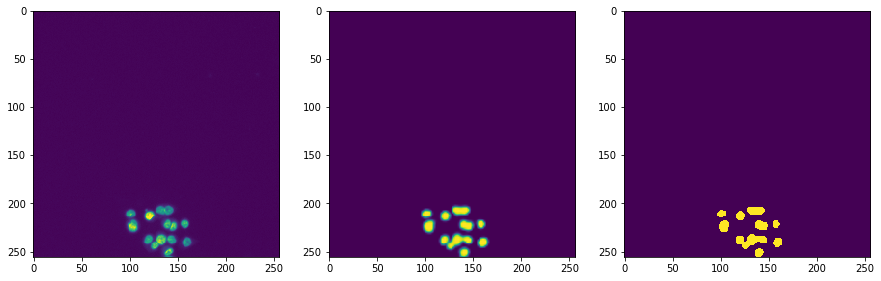

Image #: 40


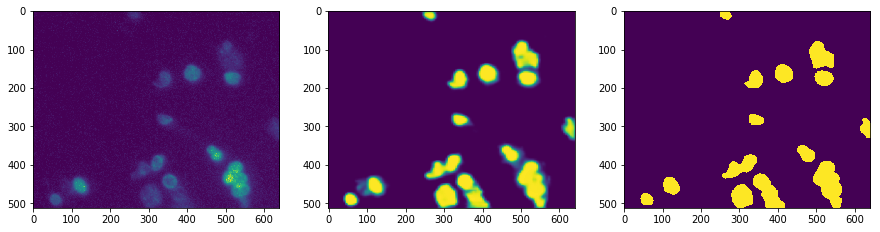

In [0]:
plot_check([test_images,preds_test_upsampled,preds_test_upsampled_bool],rand_imgs=2)

In [0]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

        
def generate_prediction_file(image_names,predictions,filename):
    new_test_ids = []
    rles = []
    for n, id_ in enumerate(image_names):
        rle = list(prob_to_rles(predictions[n]))
        rles.extend(rle)
        new_test_ids.extend([id_] * len(rle))
    sub = pd.DataFrame()
    sub['ImageId'] = new_test_ids
    sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
    sub.to_csv(filename, index=False)

In [0]:
generate_prediction_file(test_dirs,preds_test_upsampled_bool,submission_filename)

Ideas
 - Experiment with compression of training data. Am I preserving as much detail
    as I can in dtype np.uint8 (values of 0 to 255) ?
- Color vs B&W?
- Combine mask and prediction images to show false positives and negatives
- What is the best resizing method? Reflect??
- Put computer vision / threshold method output as an input to neural net
- Output intermediate layers for inspection
- Crop images to train networks faster for testing ??
- Take random crops of images to create, and then combine outputs in the end
- Is combining the masks really the best thing to do? Should I be keeping the individual cells separate?
- Pseudo-labelled data